In [5]:
!pip install GPUtil

  Using cached GPUtil-1.4.0-py3-none-any.whl


In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()


from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |


In [2]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install captum
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ayushimehrotra123","key":"5739f2d0b63b057c29700575e302ac01"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c aptos2019-blindness-detection

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|█████████████████████████████████████▉| 9.51G/9.51G [05:27<00:00, 30.8MB/s]
100%|██████████████████████████████████████| 9.51G/9.51G [05:27<00:00, 31.2MB/s]


In [4]:
import zipfile 
with zipfile.ZipFile('./aptos2019-blindness-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./blindness')

## Import Libraries

In [3]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


## EDA

I am using only the data from https://www.kaggle.com/c/aptos2019-blindness-detection/data. If you've more computing resources, you can also use the data from https://www.kaggle.com/c/diabetic-retinopathy-detection/data.

In [8]:
path = "blindness/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


## Preprocess the Data

In [9]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.
            

In [10]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [11]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=15,shuffle=False) #DataLoader for validation_set.

## Build the Model

In [12]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet18 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet18 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),nn.Linear(256,128),nn.Linear(128,64),nn.Linear(64,5))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model.load_state_dict(torch.load('model/model.pth'))

<All keys matched successfully>

In [14]:
model = model.to(device) #Moves the model to the device.

## Create functions for Training & Validation

In [13]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
        gc.collect()
        torch.cuda.empty_cache()
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [14]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    gc.collect()
    torch.cuda.empty_cache()
    return avg_loss

## Optimize the Model

In [15]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 30
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/30
-------------------------------

Training Loss per batch = 1.605963	Accuracy on Training set = 10.357359% [342/3302]

Validation Loss per batch = 1.583905	Accuracy on Validation set = 22.777778% [82/360]

Epoch 2/30
-------------------------------

Training Loss per batch = 1.578422	Accuracy on Training set = 37.976984% [1254/3302]

Validation Loss per batch = 1.561573	Accuracy on Validation set = 60.000000% [216/360]

Epoch 3/30
-------------------------------

Training Loss per batch = 1.551222	Accuracy on Training set = 66.989703% [2212/3302]

Validation Loss per batch = 1.526716	Accuracy on Validation set = 63.333333% [228/360]

Epoch 4/30
-------------------------------

Training Loss per batch = 1.516833	Accuracy on Training set = 64.688068% [2136/3302]

Validation Loss per batch = 1.493306	Accuracy on Validation set = 65.833333% [237/360]

Epoch 5/30
-------------------------------

Training Loss per batch = 1.473782	Accuracy on Training set = 65.263477% [2155/3302]


In [23]:
torch.save(model.state_dict(), 'model/model.pth')

## Testing the model

In [16]:
!pip install captum
!pip install cleverhans
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import LimeBase
from captum.attr import KernelShap
from captum.attr import Occlusion
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
# from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
# from cleverhans.torch.attacks.projected_gradient_descent import (
#     projected_gradient_descent
# )
clear_output()

In [17]:
def compute_mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    
def compute_median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 
def compute_iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    
def compute_coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

def compute_coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25)
        scores.append(score_qt)
    return scores
    

In [28]:
gc.collect()
torch.cuda.empty_cache()
print("Before Testing")
gpu_usage()

igmedianAbs_ben = []
igmeanAbs_ben = []
igiqr_ben = []
igcoef_var_ben=[]
igcoef_iqr_ben = []

igmedianAbs_bena = []
igmeanAbs_bena = []
igiqr_bena = []
igcoef_var_bena=[]
igcoef_iqr_bena = []

dataiter = iter(valid_dataloader)

for batch,(images,labels) in enumerate(valid_dataloader):    
    # (images,labels) = next(dataiter)
    images = images.to(device)
    for ind in range(15):
        gc.collect()
        torch.cuda.empty_cache()
        input1 = images[ind].unsqueeze(0)
        x_logits = model(input1)
        ig = IntegratedGradients(model)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        igmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        igiqr_ben += compute_iqr(a_batch_benign)
        igcoef_var_ben += compute_coef_var(a_batch_benign)
        igcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        gc.collect()
        torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.1, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        gc.collect()
        torch.cuda.empty_cache()
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        igmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        igiqr_bena += compute_iqr(a_batch_attack)
        igcoef_var_bena += compute_coef_var(a_batch_attack)
        igcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
        gc.collect()
        torch.cuda.empty_cache()
        # print("Testing")
        # gpu_usage()


Before Testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 11% |


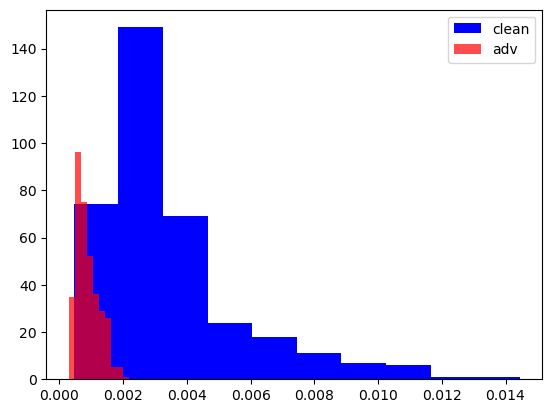

In [29]:
plt.hist(igiqr_ben, label='clean', color='blue')
plt.hist(igiqr_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()

In [30]:
gc.collect()
torch.cuda.empty_cache()

salmedianAbs_ben = []
salmeanAbs_ben = []
saliqr_ben = []
salcoef_var_ben=[]
salcoef_iqr_ben = []

salmedianAbs_bena = []
salmeanAbs_bena = []
saliqr_bena = []
salcoef_var_bena=[]
salcoef_iqr_bena = []

dataiter = iter(valid_dataloader)

for batch,(images,labels) in enumerate(valid_dataloader):    
    # (images,labels) = next(dataiter)
    images = images.to(device)
    for ind in range(15):
        gc.collect()
        torch.cuda.empty_cache()
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        ig = Saliency(model)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        salmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        salmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        saliqr_ben += compute_iqr(a_batch_benign)
        salcoef_var_ben += compute_coef_var(a_batch_benign)
        salcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        gc.collect()
        torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.1, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        gc.collect()
        torch.cuda.empty_cache()
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
        salmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        salmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        saliqr_bena += compute_iqr(a_batch_attack)
        salcoef_var_bena += compute_coef_var(a_batch_attack)
        salcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
        gc.collect()
        torch.cuda.empty_cache()


/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


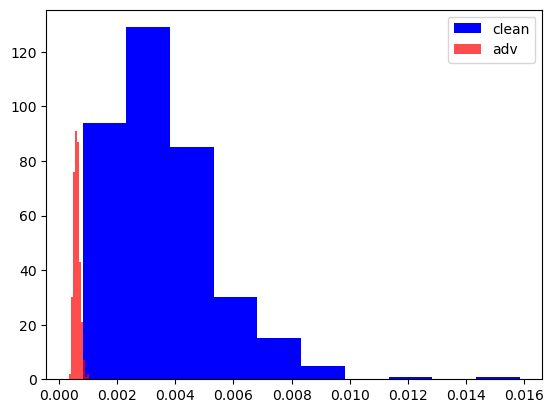

In [31]:
plt.hist(saliqr_ben, label='clean', color='blue')
plt.hist(saliqr_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

gradmedianAbs_ben = []
gradmeanAbs_ben = []
gradiqr_ben = []
gradcoef_var_ben=[]
gradcoef_iqr_ben = []

gradmedianAbs_bena = []
gradmeanAbs_bena = []
gradiqr_bena = []
gradcoef_var_bena=[]
gradcoef_iqr_bena = []

dataiter = iter(valid_dataloader)

for batch,(images,labels) in enumerate(valid_dataloader):    
    # (images,labels) = next(dataiter)
    images = images.to(device)
    for ind in range(15):
        gc.collect()
        torch.cuda.empty_cache()
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        ig = GradientShap(model)
        rand_img_dist = torch.cat([input1 * 0, input1 * 1])
        a_batch_benign = ig.attribute(input1, target=labels[ind],baselines=rand_img_dist).sum(axis=1).cpu().detach().numpy()
        gradmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        gradmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        gradiqr_ben += compute_iqr(a_batch_benign)
        gradcoef_var_ben += compute_coef_var(a_batch_benign)
        gradcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        gc.collect()
        torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.05, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        gc.collect()
        torch.cuda.empty_cache()
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd,baselines=rand_img_dist).sum(axis=1).cpu().detach().numpy()
        gradmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        gradmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        gradiqr_bena += compute_iqr(a_batch_attack)
        gradcoef_var_bena += compute_coef_var(a_batch_attack)
        gradcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
        gc.collect()
        torch.cuda.empty_cache()


/tmp/ipykernel_19/890496051.py:38: RuntimeWarning: invalid value encountered in scalar divide
  sc = m/st
/tmp/ipykernel_19/890496051.py:48: RuntimeWarning: invalid value encountered in scalar divide
  score_qt = (score_75 - score_25)/(score_75 + score_25)


In [ ]:
plt.hist(gradmedianAbs_ben, label='clean', color='blue')
plt.hist(gradmedianAbs_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()

We can able to increase the accuracy of the model by various ways, like increasing the dataset size, increasing the model complexity, using ensemble models, and increasing the number of epochs.